In [1]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [15]:
# Download NIFTY 50 data
price_df = yf.download("^NSEI", start="2018-01-01")
price_df = price_df.reset_index()

# Convert to Prophet format
price_df = price_df[["Date", "Close"]]
price_df.columns = ["ds", "y"]

price_df["ds"] = pd.to_datetime(price_df["ds"])
price_df.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2018-01-02,10442.200195
1,2018-01-03,10443.200195
2,2018-01-04,10504.799805
3,2018-01-05,10558.849609
4,2018-01-08,10623.599609


In [16]:
sentiment_df = pd.read_csv("C:\\Users\\ayush\\OneDrive\\Desktop\\alphagaze\\data\\daily_sentiment.csv")
sentiment_df["ds"] = pd.to_datetime(sentiment_df["ds"])

sentiment_df.head()


,ds,sentiment
0,2025-02-07,0.605220
1,2025-02-10,0.025723
2,2025-02-11,0.419806
3,2025-02-12,0.481427
4,2025-02-13,0.760332


In [24]:
print("Price data range:")
print(price_df["ds"].min(), "→", price_df["ds"].max())

print("\nSentiment data range:")
print(sentiment_df["ds"].min(), "→", sentiment_df["ds"].max())


Price data range:
2018-01-02 00:00:00 → 2026-02-09 00:00:00

Sentiment data range:
2025-02-07 00:00:00 → 2025-08-21 00:00:00


In [17]:
# Merge on date
fusion_df = pd.merge(price_df, sentiment_df, on="ds", how="left")

# Fill missing sentiment with 0 (no news day = neutral)
fusion_df["sentiment"] = fusion_df["sentiment"].fillna(0)

fusion_df.head()


,ds,y,sentiment
0,2018-01-02,10442.200195,0.0
1,2018-01-03,10443.200195,0.0
2,2018-01-04,10504.799805,0.0
3,2018-01-05,10558.849609,0.0
4,2018-01-08,10623.599609,0.0


In [19]:
baseline_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True
)

baseline_model.fit(price_df)

future_baseline = baseline_model.make_future_dataframe(periods=30)
forecast_baseline = baseline_model.predict(future_baseline)

18:57:02 - cmdstanpy - INFO - Chain [1] start processing
18:57:03 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
fusion_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True
)

# Add sentiment as external regressor
fusion_model.add_regressor("sentiment")

fusion_model.fit(fusion_df)


18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Create future dates
future_fusion = fusion_model.make_future_dataframe(periods=30)

# Merge sentiment into future dataframe
future_fusion = pd.merge(
    future_fusion,
    sentiment_df,
    on="ds",
    how="left"
)

# Fill missing future sentiment with 0
future_fusion["sentiment"] = future_fusion["sentiment"].fillna(0)

forecast_fusion = fusion_model.predict(future_fusion)


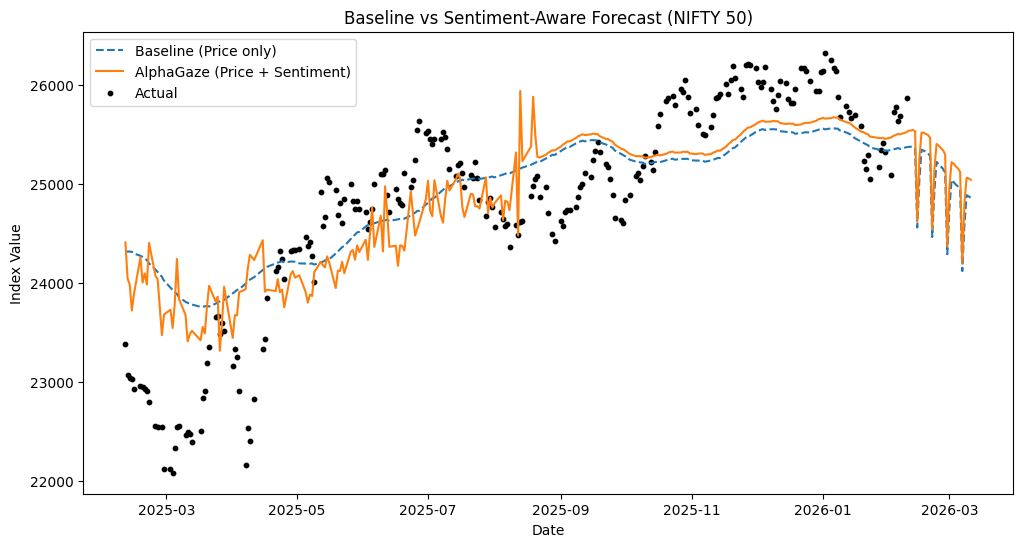

In [22]:
cutoff_date = price_df["ds"].max() - pd.DateOffset(years=1)

plt.figure(figsize=(12, 6))

# Baseline forecast
plt.plot(
    forecast_baseline[forecast_baseline["ds"] >= cutoff_date]["ds"],
    forecast_baseline[forecast_baseline["ds"] >= cutoff_date]["yhat"],
    label="Baseline (Price only)",
    linestyle="--"
)

# Fusion forecast
plt.plot(
    forecast_fusion[forecast_fusion["ds"] >= cutoff_date]["ds"],
    forecast_fusion[forecast_fusion["ds"] >= cutoff_date]["yhat"],
    label="AlphaGaze (Price + Sentiment)"
)

# Actual values
actual = price_df[price_df["ds"] >= cutoff_date]
plt.scatter(actual["ds"], actual["y"], color="black", s=10, label="Actual")

plt.title("Baseline vs Sentiment-Aware Forecast (NIFTY 50)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.show()


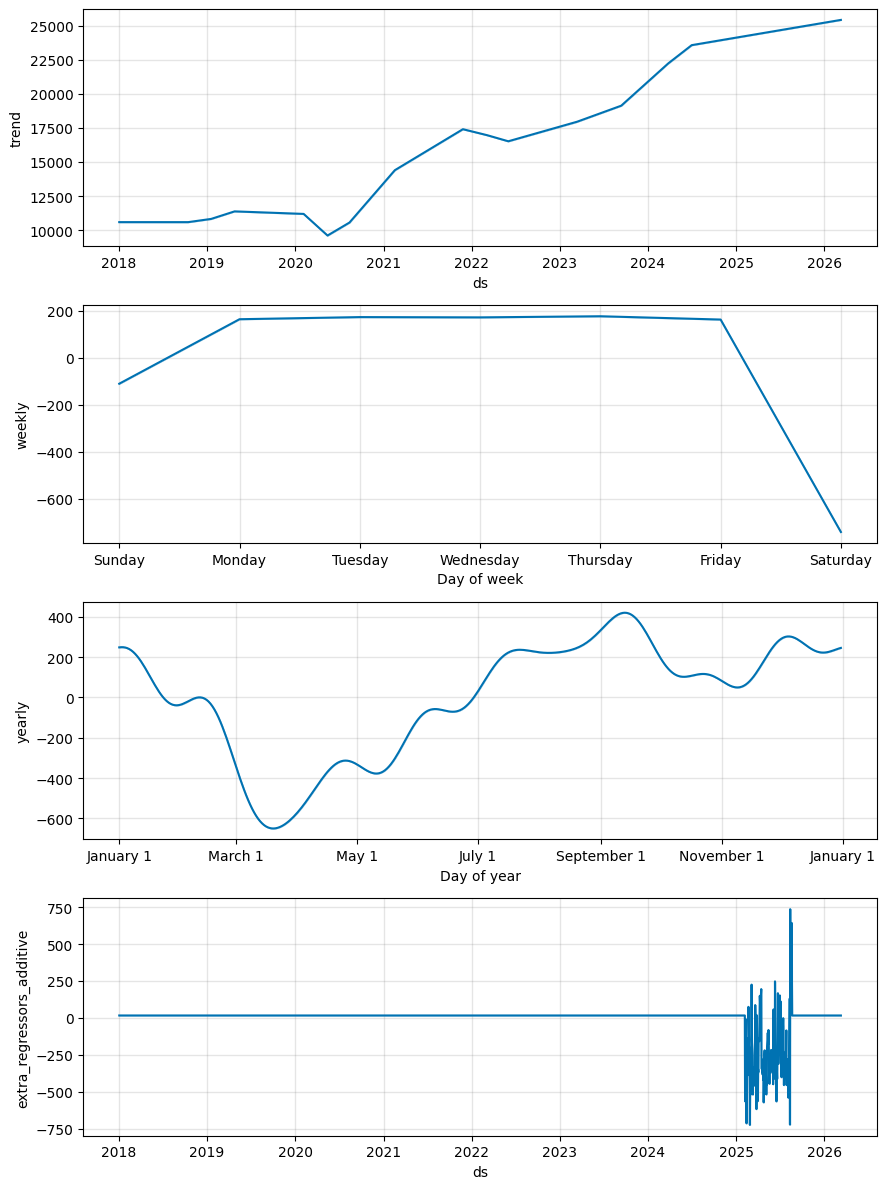

In [23]:
fusion_model.plot_components(forecast_fusion)
plt.show()